<p align="center">
  <img width="600" height="300" src="https://www.h-h-c.com/wp-content/uploads/2021/08/Lobar-Pneumonia.png">
</p>

# **ABOUT DATASET**

<p align="center">
  <img width="630" height="350" src="https://assets.aboutkidshealth.ca/akhassets/Pneumonia_XRAY_MEDIMG_PHO_EN.png?RenditionID=19">
</p>

The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

# **Import Libraries and Download Data**

In [1]:
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import tensorflow as tf
from keras import backend as K
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import plot_model
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import *

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download paultimothymooney/chest-xray-pneumonia
!unzip /content/chest-xray-pneumonia.zip

# **Preprocessing & Data Visualisation**

In [5]:
base_dir = 'chest_xray'

print('Contents of base directory:')
print(os.listdir(base_dir))

print('\nContents of train directory:')
print(os.listdir(f'{base_dir}/train'))

print('\nContents of val directory:')
print(os.listdir(f'{base_dir}/val'))

print('\nContents of test directory:')
print(os.listdir(f'{base_dir}/test'))

Contents of base directory:
['train', 'chest_xray', 'val', '__MACOSX', 'test']

Contents of train directory:
['PNEUMONIA', 'NORMAL']

Contents of val directory:
['PNEUMONIA', 'NORMAL']

Contents of test directory:
['PNEUMONIA', 'NORMAL']


In [6]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

#Directory with training NORMAL/PNEUMONIA pictures
train_NORMAL_dir = os.path.join(train_dir, 'NORMAL')
train_PNEUMONIA_dir = os.path.join(train_dir, 'PNEUMONIA')

#Directory with validation NORMAL/PNEUMONIA pictures
val_NORMAL_dir = os.path.join(val_dir, 'NORMAL')
val_PNEUMONIA_dir = os.path.join(val_dir, 'PNEUMONIA')

#Directory with test NORMAL/PNEUMONIA pictures
test_NORMAL_dir = os.path.join(test_dir, 'NORMAL')
test_PNEUMONIA_dir = os.path.join(test_dir, 'PNEUMONIA')

In [7]:
#These variables store lists of filenames found in the directories specified by train_NORMAL_dir and train_PNEUMONIA_dir
train_NORMAL_fnames = os.listdir(train_NORMAL_dir)
train_PNEUMONIA_fnames = os.listdir(train_PNEUMONIA_dir) #os module is used to obtain a list of filenames in the specified directories.

print(train_NORMAL_fnames[:5])  #prints the first five filenames
print(train_PNEUMONIA_fnames[:5])

['NORMAL2-IM-0452-0001.jpeg', 'NORMAL2-IM-0849-0001.jpeg', 'NORMAL2-IM-1054-0001.jpeg', 'IM-0539-0001.jpeg', 'NORMAL2-IM-0757-0001.jpeg']
['person1010_virus_1695.jpeg', 'person36_bacteria_183.jpeg', 'person1158_bacteria_3103.jpeg', 'person1202_virus_2045.jpeg', 'person600_bacteria_2457.jpeg']


In [8]:
pneumonia = os.listdir("chest_xray/train/PNEUMONIA")
pneumonia_dir = "chest_xray/train/PNEUMONIA"

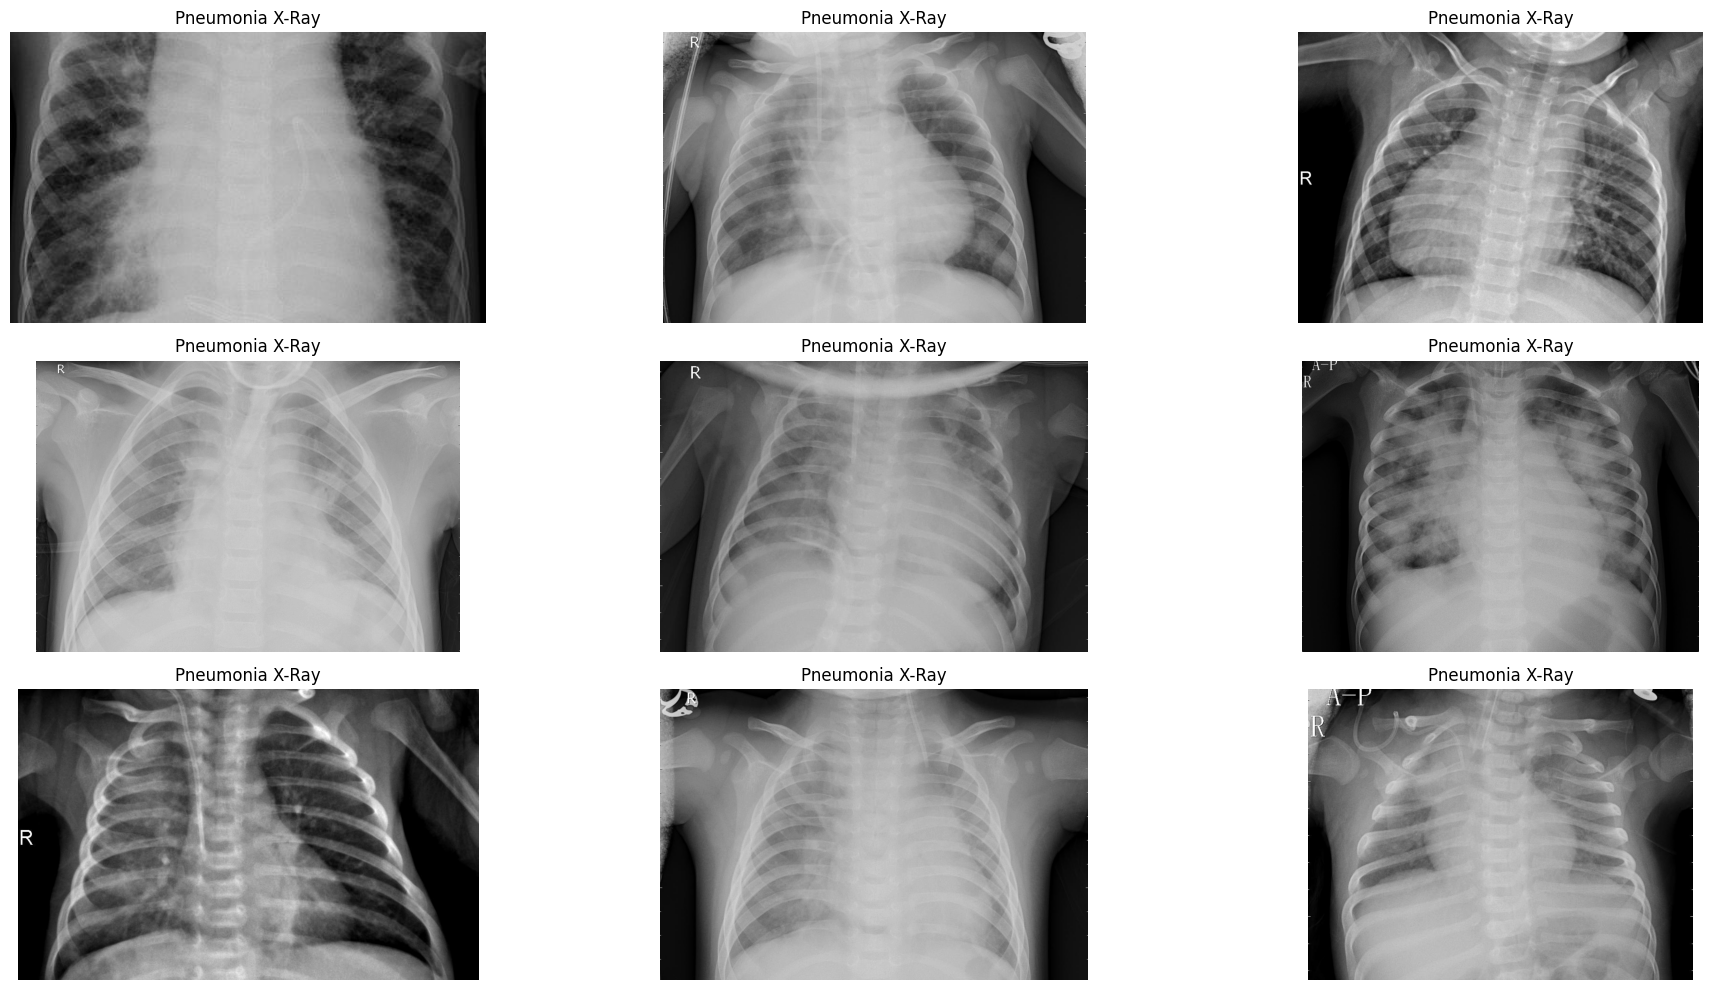

In [9]:
plt.figure(figsize=(20, 10))

for i in range(9): # for loop that iterates from 0 to 8
    plt.subplot(3, 3, i + 1) #number of rows,number of columns and the index of the current subplot (i + 1).
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i])) # reads an image file from a directory
    plt.imshow(img, cmap='gray') #displays the image in grayscale using Matplotlib's imshow function.
      #It takes the img variable, which contains the image data, and displays it in the current subplot.
    plt.axis('off')   #turns off the axis labels and ticks
    plt.title("Pneumonia X-Ray")
plt.tight_layout()
plt.savefig("pneumonia_xray_images.jpeg", format='jpeg', dpi=400, bbox_inches='tight')
#DPI (dots per inch), and bbox_inches to ensure that the saved image is of good quality and doesn't cut off any content.

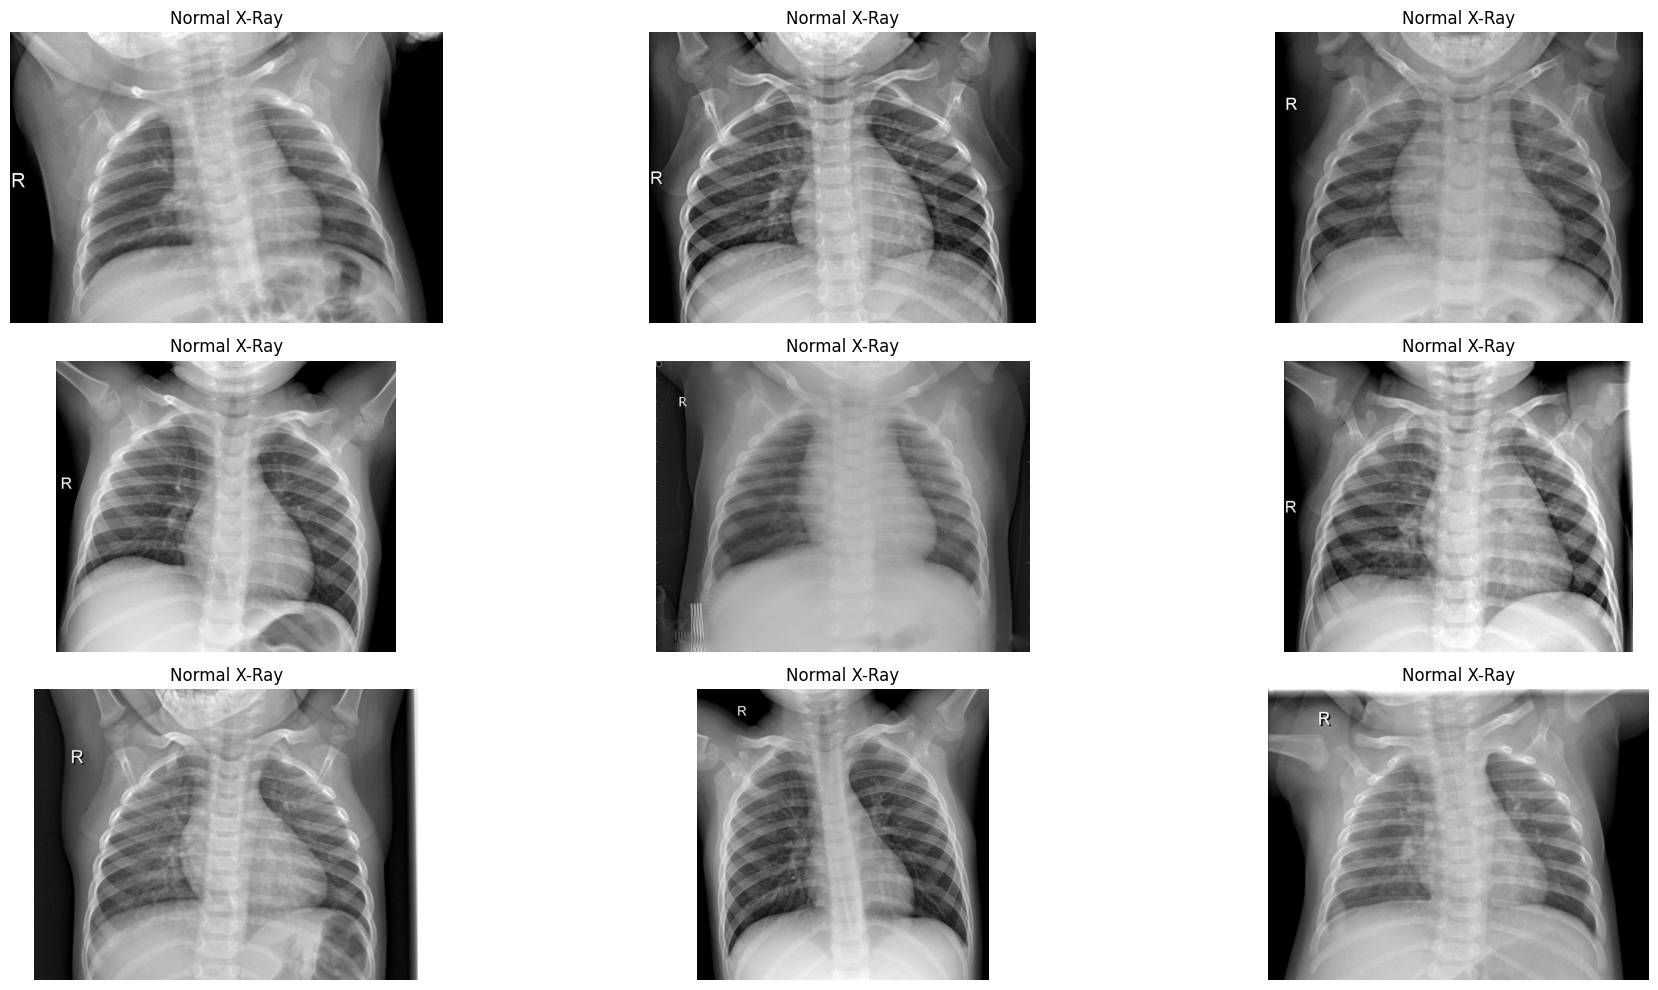

In [10]:
normal = os.listdir("chest_xray/train/NORMAL")
normal_dir = "chest_xray/train/NORMAL"

plt.figure(figsize=(20, 10))

for i in range(9):  # for loop that iterates from 0 to 8
    plt.subplot(3, 3, i + 1) #number of rows,number of columns and the index of the current subplot (i + 1).
    img = plt.imread(os.path.join(normal_dir, normal[i])) # reads an image file from a directory
    plt.imshow(img, cmap='gray') #displays the image in grayscale using Matplotlib's imshow function.
      #It takes the img variable, which contains the image data, and displays it in the current subplot.
    plt.axis('off')  #turns off the axis labels and ticks
    plt.title("Normal X-Ray")

plt.tight_layout()
plt.savefig("normal_xray_images.jpeg", format='jpeg', dpi=400, bbox_inches='tight')
#DPI (dots per inch), and bbox_inches to ensure that the saved image is of good quality and doesn't cut off any content.

As you see, by just observing we cannot tell the difference between the affected lungs and the normal ones. Let's see how well our models work to classify the x-rays.

In [11]:
train_dir = "chest_xray/train/"
test_dir = "chest_xray/test/"
valid_dir = "chest_xray/val/"


normal_train = os.listdir("chest_xray/train/NORMAL")
normal_train_dir = "chest_xray/train/NORMAL"
normal_val = os.listdir("chest_xray/val/NORMAL")
normal_val_dir = "chest_xray/val/NORMAL"
normal_test = os.listdir("chest_xray/test/NORMAL")
normal_test_dir = "chest_xray/test/NORMAL"

pneumonia_train = os.listdir("chest_xray/train/PNEUMONIA")
pneumonia_train_dir = "chest_xray/train/PNEUMONIA"
pneumonia_val = os.listdir("chest_xray/val/PNEUMONIA")
pneumonia_val_dir = "chest_xray/val/PNEUMONIA"
pneumonia_test = os.listdir("chest_xray/test/PNEUMONIA")
pneumonia_test_dir = "chest_xray/test/PNEUMONIA"

In [12]:
print("{} Infected training images".format(len(os.listdir(pneumonia_train_dir))))
print("{} Normal training images".format(len(os.listdir(normal_train_dir))))
print(" {} Infected valid images".format(len(os.listdir(pneumonia_val_dir))))
print(" {} Normal valid images".format(len(os.listdir(normal_val_dir))))
print(" {} Infected testing images".format(len(os.listdir(pneumonia_test_dir))))
print(" {} Normal testing images".format(len(os.listdir(normal_test_dir))))

3875 Infected training images
1341 Normal training images
 8 Infected valid images
 8 Normal valid images
 390 Infected testing images
 234 Normal testing images


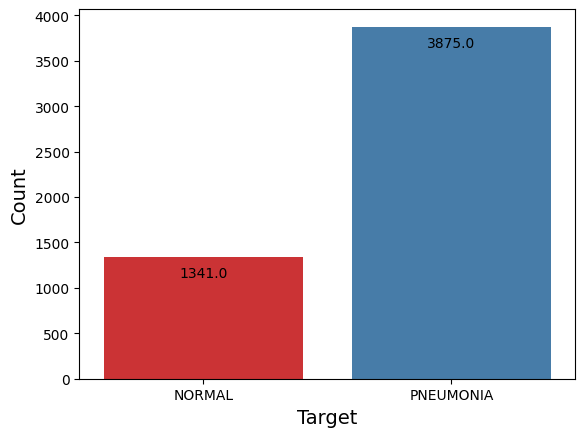

In [13]:
#x argument specifies the category labels ('NORMAL' and 'PNEUMONIA'), and the y argument provides the corresponding counts.
ax = sns.barplot(x = ['NORMAL', 'PNEUMONIA'], y = [len(os.listdir(train_NORMAL_dir)), len(os.listdir(train_PNEUMONIA_dir))]
            , palette = 'Set1') #palette argument sets the color palette for the bars to 'Set1'
for p in ax.patches:
    ax.annotate(format(p.get_height()),   #calculates the height of the bar
                   (p.get_x() + p.get_width() / 2., p.get_height()),  #positions the annotation text at the center of the bar
                   ha = 'center', va = 'center',
                   xytext = (0, -12),   #specifies the offset for the text, moving it slightly below the top of the bar.
                   textcoords = 'offset points')
    #When set to 'offset points', it means that xytext will be interpreted as an offset from the data coordinates.
plt.xlabel('Target', size=14)
plt.ylabel('Count', size=14);

our datset is imbalanced. About 75 $\%$ of the train data has PNEUMONIA label.

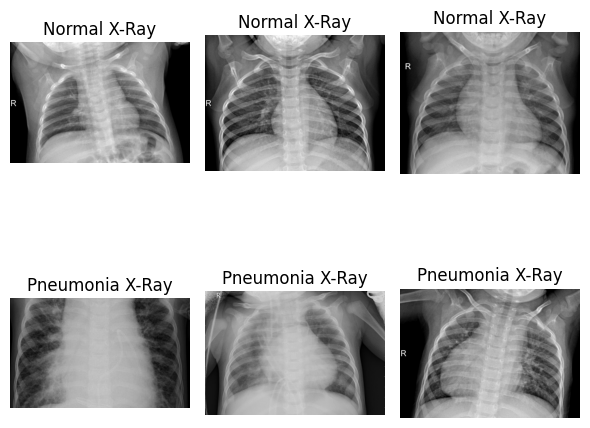

In [14]:
# Visualize a few X-ray images from both classes
plt.figure(figsize=(6, 6))

# Visualize Normal X-ray
for i in range(3):
    plt.subplot(2, 3, i + 1) #sets up a subplot in a 2x3 grid, where the first row is reserved for normal X-ray images.
    img = plt.imread(os.path.join(train_NORMAL_dir, train_NORMAL_fnames[i])) #reads an image file from the "NORMAL" directory
    plt.imshow(img, cmap='gray') #displays the image in grayscale
    plt.axis('off')
    plt.title("Normal X-Ray")

# Visualize Pneumonia X-ray
for i in range(3):
    plt.subplot(2, 3, i + 4)
    img = plt.imread(os.path.join(train_PNEUMONIA_dir, train_PNEUMONIA_fnames[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title("Pneumonia X-Ray")

plt.tight_layout()
plt.show()

For the data augmentation, we:

* Randomly rotate some training images by 30 degrees
* Randomly Zoom by 20% some training images
* Randomly shift images horizontally by 10% of the width
* Randomly shift images vertically by 10% of the height
* Randomly flip images horizontally

All images will be rescaled by 1./255 and also I use greyscale images (1 channel)

# **Data Augmentation and Resizing**

In [15]:
train_datagen = ImageDataGenerator(rescale = 1.0/255.,
                                   featurewise_center=False,  # set input mean to 0 over the dataset
                                   samplewise_center=False,  # set each sample mean to 0
                                   featurewise_std_normalization=False,  # divide inputs by std of the dataset
                                   samplewise_std_normalization=False,  # divide each input by its std
                                   zca_whitening=False,  # apply ZCA whitening
                                   rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
                                   zoom_range = 0.2, # Randomly zoom image
                                   width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                                   height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
                                   horizontal_flip = True,  # randomly flip images
                                   vertical_flip=False)
#scales the pixel values of the images to be in the range [0, 1] by dividing all pixel values by 255.
val_datagen = ImageDataGenerator(rescale = 1.0/255.)
test_datagen  = ImageDataGenerator(rescale = 1.0/255.)

# --------------------
#Flow training images in batches of 20 using train_datagen generator
# --------------------
#train_generator, val_generator, and test_generator are created using the flow_from_directory method.
#generators read and preprocess image data from specific directories(train_dir, val_dir, and test_dir) during training, validation, and testing
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 64, #specifies the number of images to include in each batch.
                                                    class_mode = 'binary', #binary as there are two classes ('NORMAL' and 'PNEUMONIA').
                                                    target_size = (128, 128), #Images will be resized to the specified dimensions
                                                    color_mode='grayscale') #images are grayscale, not in color.
# --------------------
#Flow validation images in batches of 20 using val_datagen generator
# --------------------
val_generator =  val_datagen.flow_from_directory(val_dir,
                                                 batch_size = 8,
                                                 class_mode = 'binary',
                                                 target_size = (128, 128),
                                                 color_mode='grayscale')
# --------------------
#Flow test images in batches of 20 using test_datagen generator
# --------------------
test_generator =  test_datagen.flow_from_directory(test_dir,
                                                   batch_size = 64,
                                                   class_mode = 'binary',
                                                   target_size = (128, 128),
                                                   color_mode='grayscale')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# **CNN**

In [16]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(128, 128, 1)), #convolutional layer with 16 filters, each of size (3,3)
     # input_shape parameter specifies that the input images should have dimensions of 128x128 pixels
     #batch normalization helps stabilize and accelerate the training of deep neural networks by normalizing the inputs to each layer.
    tf.keras.layers.BatchNormalization(),
    #max-pooling layer with a pool size of (2,2).
    #It reduces the spatial dimensions of the feature maps, helping to capture important information while reducing computational complexity.
    tf.keras.layers.MaxPooling2D(2,2),
    #convolutional layer with 32 filters and a (3,3) kernel size
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #flattens the 2D feature maps into a 1D vector, preparing the data for the fully connected layers.
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid') #output layer with a single unit and a sigmoid activation function.
    #It produces a binary classification output where values close to 0 represent "NORMAL" and values close to 1 represent "PNEUMONIA."
])

In [17]:
model.summary()

#Each layer is described with its type, such as "Conv2D," "BatchNormalization," "MaxPooling2D," "Flatten," and "Dense" (fully connected layer).
#The layers are numbered automatically in the order they appear in the model.
#(None, 126, 126, 16) represents an output with a batch size of "None," an image shape of 126x126 pixels, and 16 feature maps.
#Param #" column specifies the number of trainable parameters in each layer.
# Trainable parameters are the weights and biases that the model learns during training.

#Trainable params: number of parameters that can be modified and learned during training.
#These parameters are updated by backpropagation during the training process.

#Non-trainable params: number of parameters that are fixed and not updated during training.
#These parameters are often related to normalization layers (e.g., BatchNormalization) or other non-learnable components of the model.

# Model Size: the total size of the model in terms of memory. In this case, it's stated as 24.59 MB.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 16)      160       
                                                                 
 batch_normalization (Batch  (None, 126, 126, 16)      64        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                        

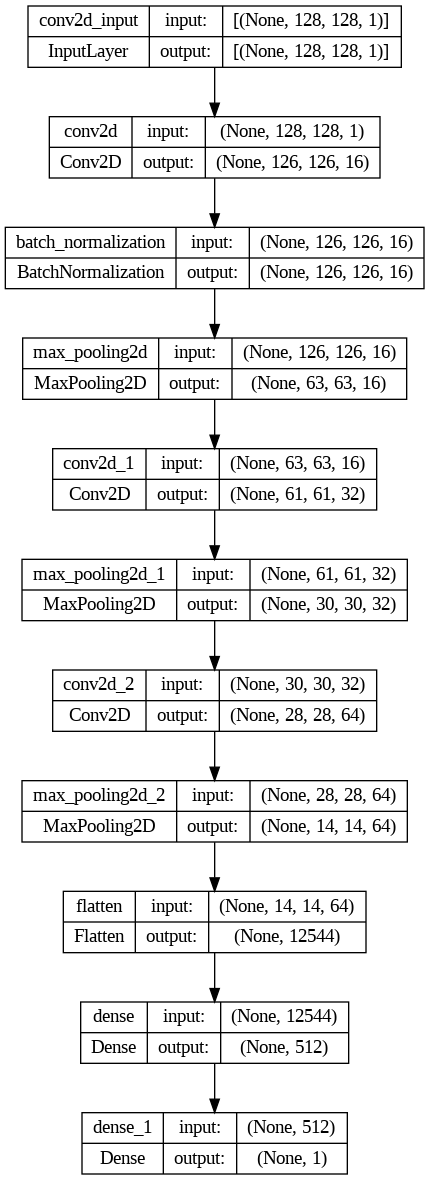

In [18]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [19]:
def recall(y_true, y_pred): # calculates the recall, also known as sensitivity or true positive rate.
  #Recall measures the proportion of true positive predictions out of all actual positive samples.
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    #computes recall by first calculating the number of true positives (samples correctly classified as positive),
    #then dividing it by the sum of true positives and any false negatives (positives classified as negatives).
    #The K.epsilon() is added to avoid division by zero.
    return recall

def precision(y_true, y_pred): #measures the proportion of true positive predictions out of all positive predictions made by the model.
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
  #computes precision by first calculating the number of true positives, then dividing it by the sum of true positives and any false positives
   #(negatives classified as positives). The K.epsilon() is added to avoid division by zero.
    return precision

def f1(y_true, y_pred):  #is the harmonic mean of precision and recall. It provides a balance between precision and recall
                    #and is often used when both false positives and false negatives are important.
    precision1 = precision(y_true, y_pred)
    recall1 = recall(y_true, y_pred)
    return 2*((precision1*recall1)/(precision1+recall1+K.epsilon()))

In [20]:
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-8), loss = 'binary_crossentropy',
              metrics = ['accuracy', f1, precision, recall])
#compile is to specify key settings for the training process, such as the optimizer, loss function, for evaluating the model's performance
# the optimizer that will be used for updating the model's weights during training
#loss function:model will minimize during training. binarycrossentropy measures the dissimilarity between the predicted and actual class labels.

Let's find the optimal learning for the CNN.

In [21]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch / 12.5))
#lambda function that determines how the learning rate should change based on the current training epoch.

In [22]:
history = model.fit(train_generator, #responsible for providing batches of training data to the model during each training iteration.
                    steps_per_epoch = 40, #specifies how many batches of data are processed per epoch.
                    #steps_per_epoch is often determined based on the size of the training dataset and the batch size.
                    epochs = 50, #number of complete passes through the entire training dataset.model will be trained for a total of 50 epochs.
                    callbacks = [lr_schedule], #callback dynamically adjusts the learning rate during training as a function of the epoch.
                    verbose = 1) #providing information about the progress of each epoch.

Epoch 1/50
40/40 [==============================] - 90s 2s/step - loss: 0.6173 - accuracy: 0.7387 - f1: 0.8487 - precision: 0.7408 - recall: 0.9958 - lr: 1.0000e-06
Epoch 2/50
40/40 [==============================] - 68s 2s/step - loss: 0.6018 - accuracy: 0.7367 - f1: 0.8473 - precision: 0.7367 - recall: 1.0000 - lr: 1.2023e-06
Epoch 3/50
40/40 [==============================] - 66s 2s/step - loss: 0.5670 - accuracy: 0.7571 - f1: 0.8607 - precision: 0.7570 - recall: 1.0000 - lr: 1.4454e-06
Epoch 4/50
40/40 [==============================] - 66s 2s/step - loss: 0.5597 - accuracy: 0.7477 - f1: 0.8544 - precision: 0.7477 - recall: 1.0000 - lr: 1.7378e-06
Epoch 5/50
40/40 [==============================] - 71s 2s/step - loss: 0.5470 - accuracy: 0.7395 - f1: 0.8487 - precision: 0.7385 - recall: 1.0000 - lr: 2.0893e-06
Epoch 6/50
40/40 [==============================] - 66s 2s/step - loss: 0.5177 - accuracy: 0.7574 - f1: 0.8592 - precision: 0.7571 - recall: 0.9964 - lr: 2.5119e-06
Epoch 7/50

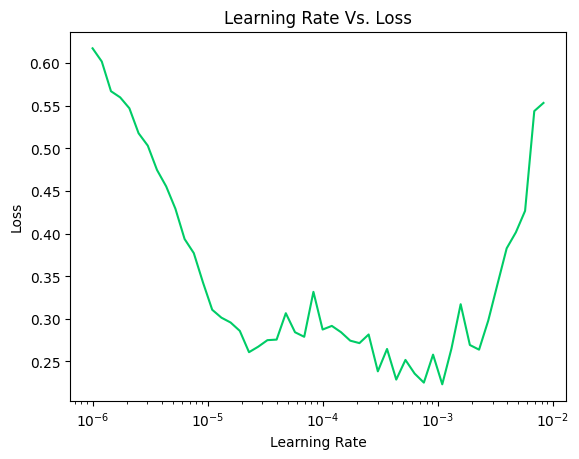

In [23]:
lrs = 1e-6 * (10 ** (np.arange(50) / 12.5)) #learning rates will start very small and gradually increase as the epoch number increases
plt.semilogx(lrs, history.history['loss'], color = '#00cc66') #creates a semilogarithmic plot (logarithmic scale on the x-axis) of
#learning rates (lrs) on the x-axis and the corresponding loss values from the training history on the y-axis
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.title('Learning Rate Vs. Loss');

It seems that $10^{-5}$ will be a good choice. However, due to limited resources I will use a higher learning rate to converge faster. If you use $10^-5$ for learning rate with the right amount of epoch, you may get a better result.

In [24]:
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-3), loss = 'binary_crossentropy',
              metrics = ['accuracy', f1, precision, recall, tf.keras.metrics.AUC(), tf.keras.metrics.TruePositives(),
                         tf.keras.metrics.TrueNegatives(), tf.keras.metrics.FalsePositives(), tf.keras.metrics.FalseNegatives()])
#compile is to specify key settings for the training process, such as the optimizer, loss function, for evaluating the model's performance
# the optimizer that will be used for updating the model's weights during training
#loss function:model will minimize during training. binarycrossentropy measures the dissimilarity between the predicted and actual class labels.
#tf.keras.metrics.AUC():computes the area under the receiver operating characteristic (ROC) curve.
#Its a measure of the model's ability to distinguish between positive and negative samples and is commonly used in binary classification tasks.

In [25]:
history = model.fit(train_generator,  #responsible for providing batches of training data to the model during each training iteration.
                    steps_per_epoch = 40,
                    epochs = 30,
                    validation_data = val_generator,
                    validation_steps = 2,
                    verbose = 1)

Epoch 1/30
40/40 [==============================] - 66s 2s/step - loss: 0.3210 - accuracy: 0.8718 - f1: 0.9163 - precision: 0.8922 - recall: 0.9465 - auc: 0.9165 - true_positives: 1790.0000 - true_negatives: 414.0000 - false_positives: 222.0000 - false_negatives: 102.0000 - val_loss: 0.5604 - val_accuracy: 0.6250 - val_f1: 0.6667 - val_precision: 0.5571 - val_recall: 0.8333 - val_auc: 0.8125 - val_true_positives: 7.0000 - val_true_negatives: 3.0000 - val_false_positives: 5.0000 - val_false_negatives: 1.0000
Epoch 2/30
40/40 [==============================] - 69s 2s/step - loss: 0.2151 - accuracy: 0.9086 - f1: 0.9390 - precision: 0.9446 - recall: 0.9350 - auc: 0.9619 - true_positives: 1768.0000 - true_negatives: 529.0000 - false_positives: 107.0000 - false_negatives: 124.0000 - val_loss: 0.5444 - val_accuracy: 0.6875 - val_f1: 0.7500 - val_precision: 0.6071 - val_recall: 1.0000 - val_auc: 0.8125 - val_true_positives: 8.0000 - val_true_negatives: 3.0000 - val_false_positives: 5.0000 - va

<ipython-input-26-e9629ea4060f>:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot  (epochs, acc, 'bo', color = '#ff0066') # plots the training accuracy using blue circles ('bo') and a red color.
<ipython-input-26-e9629ea4060f>:26: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot  (epochs, loss, 'bo', color = '#ff0066') #plots the training loss using blue circles ('bo') and a red color.


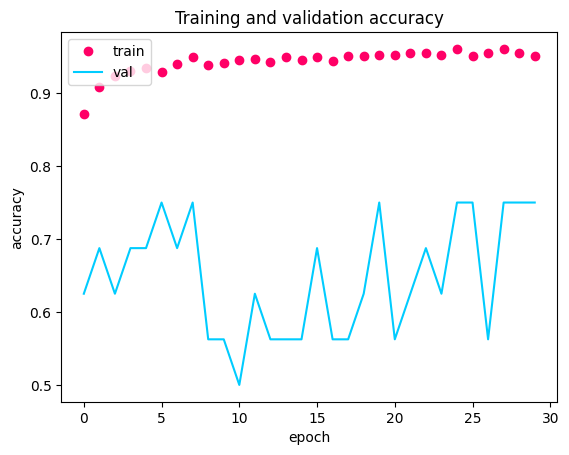

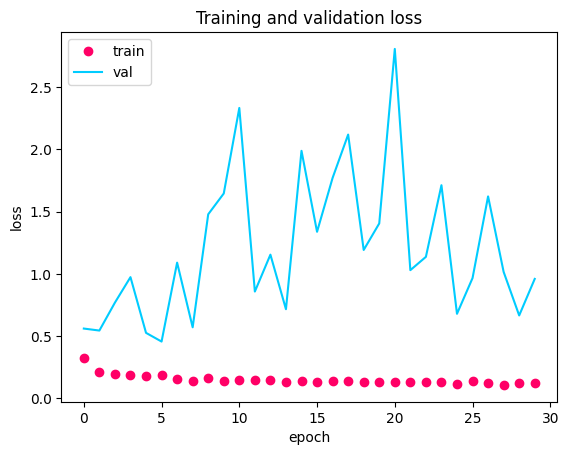

In [26]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history['accuracy'] #stores the training accuracy.
val_acc  = history.history['val_accuracy'] #stores the validation accuracy.
loss     = history.history['loss'] #stores the training loss.
val_loss = history.history['val_loss'] #stores the validation loss.

epochs   = range(len(acc)) # represents the number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc, 'bo', color = '#ff0066') # plots the training accuracy using blue circles ('bo') and a red color.
plt.plot  (epochs, val_acc, color = '#00ccff') #plots the validation accuracy using a blue color.
plt.title ('Training and validation accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss, 'bo', color = '#ff0066') #plots the training loss using blue circles ('bo') and a red color.
plt.plot  (epochs, val_loss, color = '#00ccff') #plots the validation loss using a blue color.
plt.legend(['train', 'val'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title ('Training and validation loss');

In [27]:
model.evaluate(test_generator)

10/10 [==============================] - 7s 681ms/step - loss: 0.4606 - accuracy: 0.8654 - f1: 0.9009 - precision: 0.8296 - recall: 0.9872 - auc: 0.9457 - true_positives: 385.0000 - true_negatives: 155.0000 - false_positives: 79.0000 - false_negatives: 5.0000


[0.4606373608112335,
 0.8653846383094788,
 0.9009071588516235,
 0.8295562863349915,
 0.9872221946716309,
 0.9457100033760071,
 385.0,
 155.0,
 79.0,
 5.0]

Recall is an important metric especially in healthcare data. Recall literally is how many of the true positives were found, i.e. how many of the correct hits were also found.

$Recall = \frac{TP}{TP+FN}$

In other words, the recall is the measure of our model correctly identifying True Positives. Thus, for all the patients who actually have Pneumonia, recall tells us how many we correctly identified as having a Pneumonia, so $97.5 \%$ recall is very impressive. What if a patient has Pneumonia, but there is no treatment given to him/her because our model predicted so? That is a situation we would like to avoid!

**CNN with class weight**

Since we have imbalanced data, we will assign class weights to each label to make sure that the model is not biased to the prevalent label.

In [28]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(128, 128, 1)),
    #2D convolutional layer with 16 filters, each of size (3, 3).
    tf.keras.layers.BatchNormalization(), # normalize the activations of the previous layer. It helps in stabilizing and accelerating training.
    tf.keras.layers.MaxPooling2D(2,2), # reducing the spatial dimensions by a factor of 2.
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'), #2D convolutional layer with 32 filters of size (3, 3).
    tf.keras.layers.MaxPooling2D(2,2), #max-pooling layer with a pool size of (2, 2).
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(), #flattens the 3D output to a 1D tensor, preparing the data for the fully connected layers.
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 16)      160       
                                                                 
 batch_normalization_1 (Bat  (None, 126, 126, 16)      64        
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 63, 63, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                      

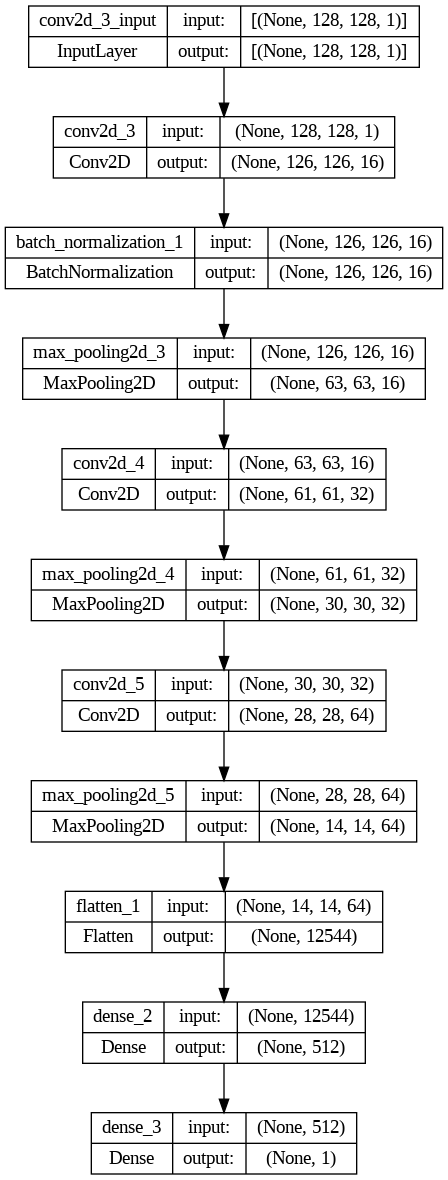

In [30]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [31]:
def recall(y_true, y_pred): #Recall measures the proportion of true positive predictions out of all actual positive samples.
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon()) #calculates recall by first computing the number of true positives #(samples
#correctly classified as positive) and then dividing it by the sum of true positives and any false negatives (positives classified as negatives).
    #K.epsilon() is added to avoid division by zero.
    return recall

def precision(y_true, y_pred): #measures the proportion of true positive predictions out of all positive predictions made by the model.
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon()) # calculates precision by first computing the number of true positives
    #and then dividing it by the sum of true positives and any false positives (negatives classified as positives).
    #K.epsilon() is added to avoid division by zero.
    return precision

def f1(y_true, y_pred): #is the harmonic mean of precision and recall. It provides a balance between precision and recall and is often used
#when both false positives and false negatives are important.
    precision1 = precision(y_true, y_pred)
    recall1 = recall(y_true, y_pred)
    return 2*((precision1*recall1)/(precision1+recall1+K.epsilon()))

In [32]:
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy', f1, precision, recall])
#rmsprop:  It adapts the learning rates of each parameter during training to speed up convergence.
#binary cross entropy:It measures the dissimilarity between predicted class probabilities and actual class labels.
#It is suitable when there are two classes (e.g., 0 and 1) to predict.

In [33]:
#weight_0 and weight_1 are calculated based on the number of samples in the two classes, specifically the train_NORMAL_dir class.
#weight_0 and weight_1 are both calculated as the total number of samples in the dataset divided by twice the number of samples in the
#train_NORMAL_dir class. The goal here is to balance the class weights so that they are inversely proportional to the class frequencies.

weight_0 = (len(os.listdir(train_NORMAL_dir)) + len(os.listdir(train_NORMAL_dir))) / (2 * len(os.listdir(train_NORMAL_dir)))
weight_1 = (len(os.listdir(train_NORMAL_dir)) + len(os.listdir(train_NORMAL_dir))) / (2 * len(os.listdir(train_NORMAL_dir)))
class_weights = {0: weight_0, 1: weight_1} #each class label (0 and 1) is associated with its corresponding class weight.
#The class weights are set to weight_0 for class 0 and weight_1 for class 1.

In [34]:
history = model.fit(train_generator, #responsible for providing batches of training data to the model during each training iteration.
                    steps_per_epoch = 40,
                    epochs = 30,
                    validation_data = val_generator,
                    validation_steps = 2,
                    class_weight = class_weights,
                    verbose = 1)

Epoch 1/30
40/40 [==============================] - 68s 2s/step - loss: 1.0551 - accuracy: 0.7009 - f1: 0.7621 - precision: 0.7297 - recall: 0.8565 - val_loss: 0.7645 - val_accuracy: 0.5000 - val_f1: 0.6667 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/30
40/40 [==============================] - 65s 2s/step - loss: 0.4556 - accuracy: 0.7729 - f1: 0.8230 - precision: 0.8713 - recall: 0.8500 - val_loss: 0.7420 - val_accuracy: 0.5000 - val_f1: 0.6667 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 3/30
40/40 [==============================] - 65s 2s/step - loss: 0.3054 - accuracy: 0.8641 - f1: 0.9064 - precision: 0.9152 - recall: 0.9117 - val_loss: 1.1943 - val_accuracy: 0.5000 - val_f1: 0.6667 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 4/30
40/40 [==============================] - 65s 2s/step - loss: 0.2925 - accuracy: 0.8766 - f1: 0.9113 - precision: 0.9247 - recall: 0.9139 - val_loss: 0.8391 - val_accuracy: 0.5625 - val_f1: 0.6894 - val_precision: 0.5446 - val_recall:

<ipython-input-35-66fe0d720fdc>:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot  (epochs, acc, 'bo', color = '#ff0066')
<ipython-input-35-66fe0d720fdc>:26: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot  (epochs, loss, 'bo', color = '#ff0066')


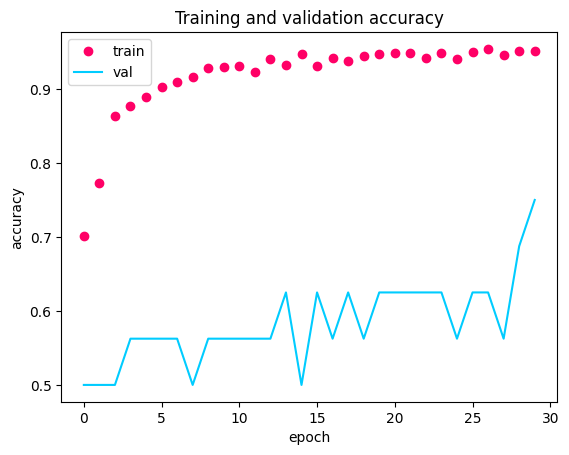

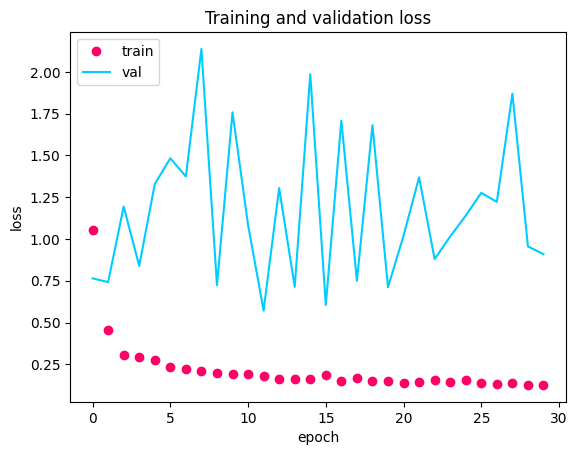

In [35]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc, 'bo', color = '#ff0066') # plots the training accuracy using blue circles ('bo') and a red color.
plt.plot  (epochs, val_acc, color = '#00ccff') #plots the validation accuracy using a blue color.
plt.title ('Training and validation accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss, 'bo', color = '#ff0066') #plots the training loss using blue circles ('bo') and a red color.
plt.plot  (epochs, val_loss, color = '#00ccff') #plots the validation loss using a blue color.
plt.legend(['train', 'val'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title ('Training and validation loss');

In [36]:
model.evaluate(test_generator)

10/10 [==============================] - 7s 673ms/step - loss: 0.3317 - accuracy: 0.8974 - f1: 0.9212 - precision: 0.8684 - recall: 0.9814


[0.3316859006881714,
 0.8974359035491943,
 0.9212462306022644,
 0.8683956265449524,
 0.9814155697822571]

Recall has been increased ($99.19\%$) when considering class weights but accuracy and precision has been decreased.

# **Transfer Learning (Inception V3)**

I have used imagenet model **InceptionV3** as my base model for pneumonia better diagnosis.

It is a technique where a pre-trained model developed for one task is used as a starting point for a different, but related, task. The idea is to leverage the knowledge and feature representations learned from one dataset and apply it to a new problem, often with a smaller dataset.

In the code you provided, InceptionV3 is mentioned. InceptionV3 is a specific deep learning architecture for image classification and object recognition. It's part of the Inception family of models and was developed by Google. InceptionV3 is trained on a large dataset known as ImageNet, which contains millions of labeled images from thousands of categories.

In [37]:
#Initialize the base model.
#Set the input shape and remove the dense layers.
pre_trained_model = InceptionV3(input_shape = (128, 128, 3), include_top = False)
#model expects input images with dimensions of 128x128 pixels and three color channels (RGB).
# include_top=False: the final dense layers (classification head) of the InceptionV3 model are excluded.

#Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = False

#For each layer, the code sets layer.trainable = False. This freezes the weights of the pre-trained layers,
#meaning that these layers will not be updated during training.
#Only the additional custom layers you add on top of the pre-trained model will be trained.

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
model = tf.keras.models.Model(inputs = pre_trained_model.inputs, outputs = pre_trained_model.get_layer('mixed7').output)
#inputs = pre_trained_model.inputs specifies that the inputs of your new model are the same as the inputs of the pre-trained InceptionV3 model.
#outputs = pre_trained_model.get_layer('mixed7').output specifies that the outputs of your new model are the activations from a specific layer
#of the pre-trained model, in this case, the 'mixed7' layer.

input_tensor = Input(shape=(128,128,1)) #indicating that it expects grayscale images with dimensions of 128x128 pixels
x = Conv2D(3,(3,3),padding='same')(input_tensor)
#input_tensor with shape (128, 128, 1), indicating that it expects grayscale images with dimensions of 128x128 pixels.
#"same" is used because it ensures that the output feature map (convolved feature map) has the same spatial dimensions as the input
x = model(x) #combines the feature extraction capabilities of InceptionV3 with your custom input layer.
x = Flatten()(x) #transforms the 3D tensor into a 1D tensor, which is required before feeding it to dense layers.
x = Dense(512, activation = 'relu')(x) #dense layer with 512 units and ReLU activation.
x = Dropout(0.1)(x) #Dropout is a regularization technique that helps prevent overfitting.
out = Dense(1, activation = 'sigmoid')(x)
model = tf.keras.models.Model(inputs = input_tensor, outputs = out)

In [39]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_100 (Conv2D)         (None, 128, 128, 3)       30        
                                                                 
 model (Functional)          (None, 6, 6, 768)         8975264   
                                                                 
 flatten_2 (Flatten)         (None, 27648)             0         
                                                                 
 dense_4 (Dense)             (None, 512)               14156288  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 513 

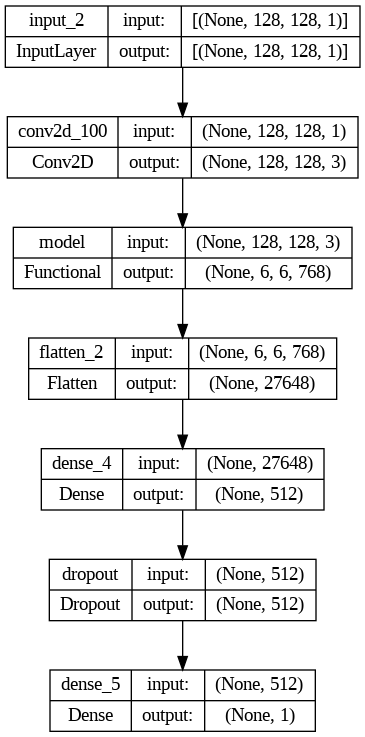

In [40]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [41]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [42]:
#Set the training parameters
model.compile(optimizer = RMSprop(learning_rate=0.0001), loss = 'binary_crossentropy',
              metrics = ['accuracy', f1_m, precision_m, recall_m])

#The optimizer is responsible for adjusting the model's weights during training to minimize the loss function.
#It measures the dissimilarity between the predicted class probabilities and the actual class labels.

#'accuracy': measures the proportion of correctly classified samples.
#f1_m: It provides a balance between precision and recall, which is valuable for binary classification.
#precision_m: calculates the proportion of true positive predictions out of all positive predictions made by the model.
#recall_m: calculates the proportion of true positive predictions out of all actual positive samples.

In [43]:
history = model.fit(train_generator,
                    steps_per_epoch = 40,
                    epochs = 15,
                    validation_data = val_generator,
                    validation_steps = 2,
                    verbose = 1)

Epoch 1/15
40/40 [==============================] - 251s 6s/step - loss: 0.3819 - accuracy: 0.8582 - f1_m: 0.9067 - precision_m: 0.8968 - recall_m: 0.9279 - val_loss: 0.4590 - val_accuracy: 0.8125 - val_f1_m: 0.7619 - val_precision_m: 1.0000 - val_recall_m: 0.6250
Epoch 2/15
40/40 [==============================] - 240s 6s/step - loss: 0.2656 - accuracy: 0.8892 - f1_m: 0.9258 - precision_m: 0.9245 - recall_m: 0.9368 - val_loss: 0.6996 - val_accuracy: 0.6250 - val_f1_m: 0.6786 - val_precision_m: 0.5417 - val_recall_m: 1.0000
Epoch 3/15
40/40 [==============================] - 241s 6s/step - loss: 0.2024 - accuracy: 0.9152 - f1_m: 0.9428 - precision_m: 0.9423 - recall_m: 0.9479 - val_loss: 0.2899 - val_accuracy: 0.8125 - val_f1_m: 0.8286 - val_precision_m: 0.8333 - val_recall_m: 0.8750
Epoch 4/15
40/40 [==============================] - 240s 6s/step - loss: 0.1968 - accuracy: 0.9227 - f1_m: 0.9481 - precision_m: 0.9464 - recall_m: 0.9532 - val_loss: 0.2716 - val_accuracy: 0.9375 - val_f1

<ipython-input-44-66fe0d720fdc>:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot  (epochs, acc, 'bo', color = '#ff0066')
<ipython-input-44-66fe0d720fdc>:26: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot  (epochs, loss, 'bo', color = '#ff0066')


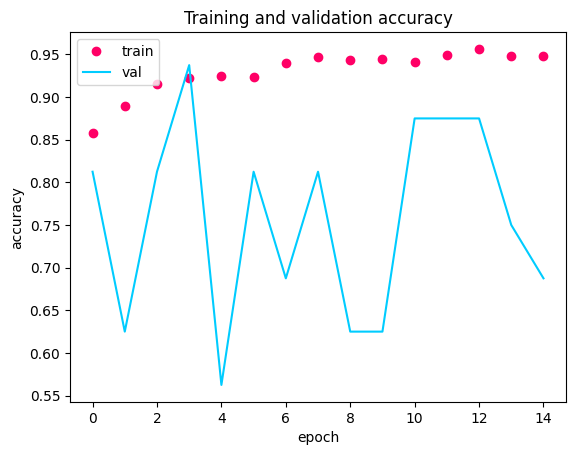

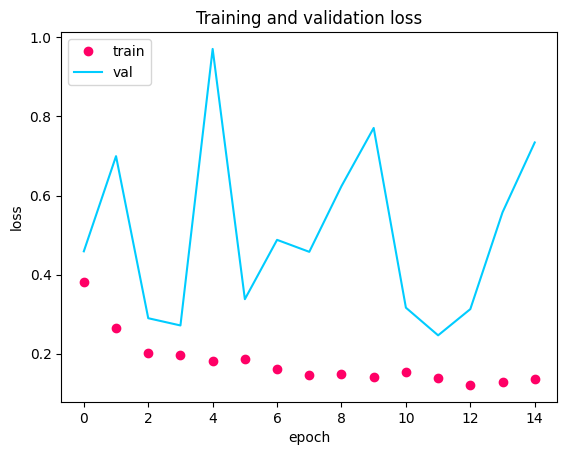

In [44]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc, 'bo', color = '#ff0066')
plt.plot  (epochs, val_acc, color = '#00ccff')
plt.title ('Training and validation accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss, 'bo', color = '#ff0066')
plt.plot  (epochs, val_loss, color = '#00ccff')
plt.legend(['train', 'val'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title ('Training and validation loss');

In [45]:
model.evaluate(test_generator)

10/10 [==============================] - 20s 2s/step - loss: 0.3956 - accuracy: 0.8622 - f1_m: 0.8988 - precision_m: 0.8280 - recall_m: 0.9845


[0.395577996969223,
 0.8621794581413269,
 0.8987951278686523,
 0.828019917011261,
 0.9844909906387329]

Recall, precision, and accuracy are higher than the previous models.